In [343]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

from typing import Dict, Any

SEED = 7

In [344]:
# Funciones auxiliares

def drop_features(train, valid, *features):
    for feature in features:
        train = train.drop(feature, axis=1)
        valid = valid.drop(feature, axis=1)
    return train, valid

def fit_and_score(model, x_train, x_valid, y_train, y_valid):
    model.fit(x_train, y_train)
    return roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])

def encode(feature, withEncother, onTrain, onValid):
    return withEncother.fit_transform(onTrain[feature]), withEncother.transform(onValid[feature])

In [345]:
test = pd.read_parquet('test')
train = pd.read_parquet('train')

In [346]:
train = train.sort_values('timedelta', ascending=False)

In [347]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train, 
    train[['popular']], 
    test_size=0.2, 
    random_state=SEED
)

In [348]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer

one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()
multilabel_binarizer = MultiLabelBinarizer()

In [350]:
surprise1_mean_encoding = lambda dataset: dataset.groupby('surprise1')['popular'].mean().to_dict()

x_train['surprise1'] = x_train['surprise1'].map(surprise1_mean_encoding(x_train))
x_valid['surprise1'] = x_valid['surprise1'].map(surprise1_mean_encoding(x_valid))

In [351]:
# multilabel_binarizer.fit_transform(train.surprise2)
unique_emotions = set()
for register in train.surprise2.map(lambda x: x.split(',')):
    unique_emotions.update(set(register))
unique_emotions

{'',
 'amusement',
 'anger',
 'annoyance',
 'disappointment',
 'disgust',
 'embarrassment',
 'fear',
 'gratitude',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'relief',
 'sadness'}

In [352]:
x_train['surprise2'] = x_train['surprise2'].map(lambda x: 'unknown' if x == '' else x)
x_valid['surprise2'] = x_valid['surprise2'].map(lambda x: 'unknown' if x == '' else x)

encoded_surprise2_train = multilabel_binarizer.fit_transform(x_train['surprise2'])
encoded_surprise2_valid = multilabel_binarizer.transform(x_valid['surprise2'])

x_train['surprise2'] = encoded_surprise2_train
x_valid['surprise2'] = encoded_surprise2_valid

In [353]:
encoded_y_train, encoded_y_valid = encode(
    feature='popular', withEncother=label_encoder,
    onTrain=y_train, onValid=y_valid
)

y_train['popular'] = encoded_y_train
y_valid['popular'] = encoded_y_valid

In [354]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', max_features=15)

In [355]:
x_train['content'] = x_train['content'].fillna('')
x_valid['content'] = x_valid['content'].fillna('')

vectorized_x_train_content = count_vectorizer.fit_transform(x_train['content'].tolist()).toarray()
x_train_content_word_count = pd.DataFrame(vectorized_x_train_content, columns=count_vectorizer.get_feature_names())

vectorized_x_valid_content = count_vectorizer.transform(x_valid['content'].tolist()).toarray()
x_valid_content_word_count = pd.DataFrame(vectorized_x_valid_content, columns=count_vectorizer.get_feature_names())

x_train['content'] = vectorized_x_train_content
x_valid['content'] = vectorized_x_valid_content

x_train = pd.concat([x_train.reset_index(), x_train_content_word_count.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), x_valid_content_word_count.reset_index()], axis=1)

In [356]:
x_train = x_train.fillna(0.0)
x_valid = x_valid.fillna(0.0)

In [357]:
x_train, x_valid = drop_features(
    x_train, x_valid,
    'url', 'popular', 'shares', 'timedelta', 'index'
)

# Modelos

## Model: XGBClassifier

### Iteraciones

#### Baseline -> Score: 0.7002464768524228

In [359]:
xgbc = XGBClassifier(n_jobs=-1, random_state=SEED)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7002464768524228

#### Iterando sobre feature importance

##### Iteración 1: Feature Importance -> Score: 0.7002464768524228

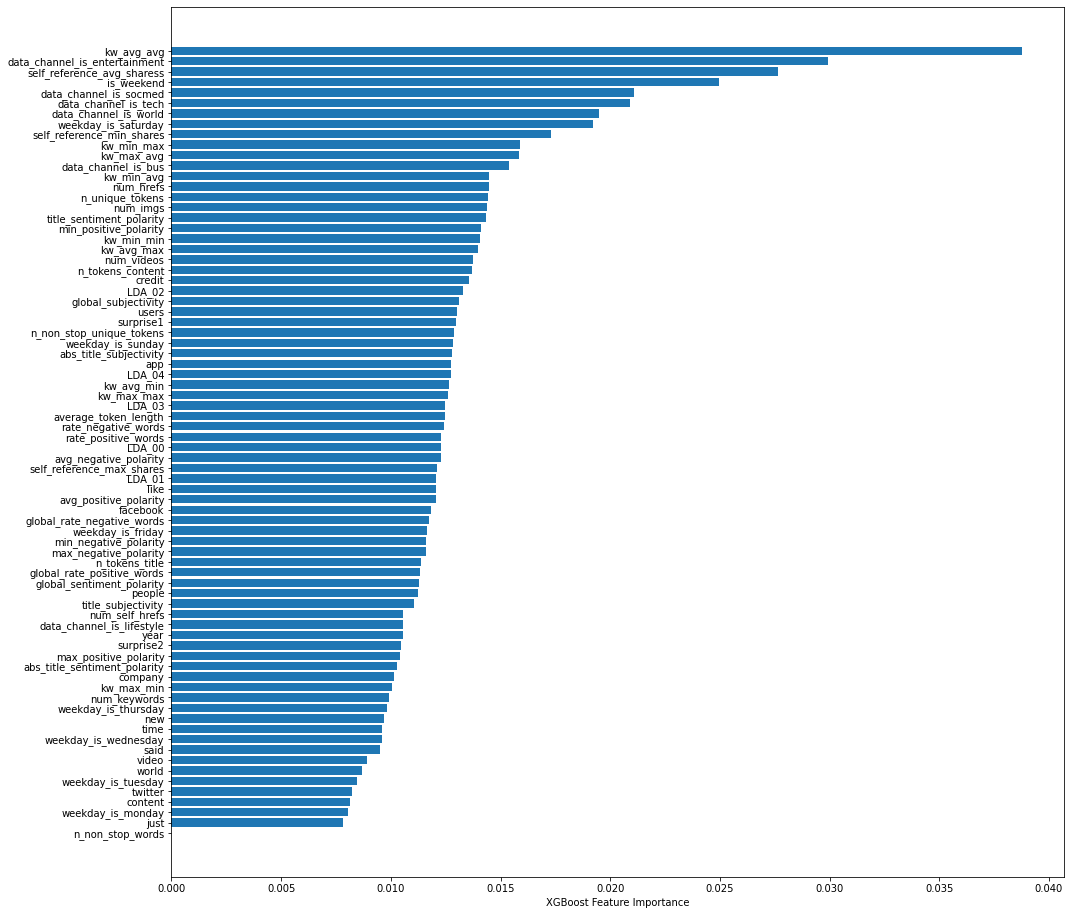

In [360]:
import matplotlib.pyplot as plt

sorted_idx = xgbc.feature_importances_.argsort()

plt.figure(figsize=(16,16))
plt.barh(xgbc.feature_names_in_[sorted_idx], xgbc.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance");

Elimino features que no tienen importancia

In [366]:
x_train, x_valid = drop_features(
    x_train, x_valid,
    'n_non_stop_words'
)

In [368]:
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7002464768524228

##### Iteración 2: Permutation Importance -> Score: 0.7003086913465073

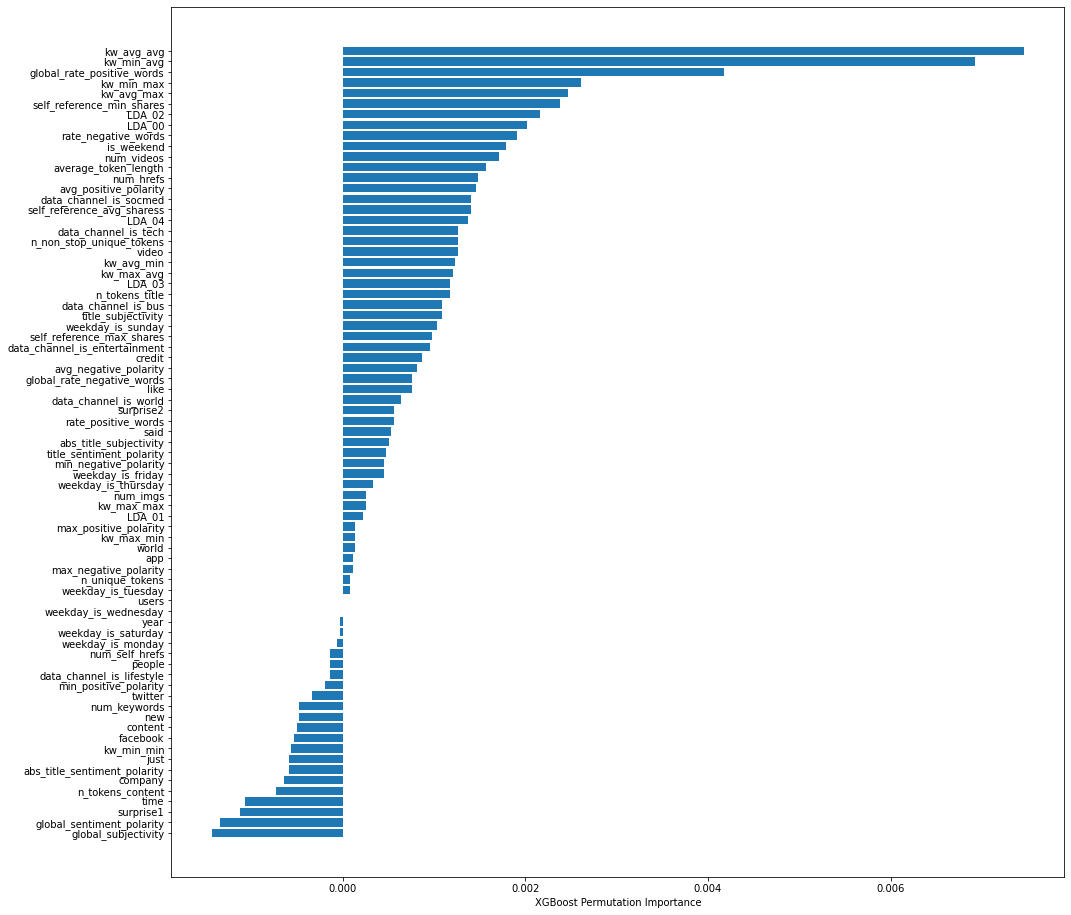

In [369]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgbc, x_valid, y_valid['popular'], random_state=SEED)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(16,16))
plt.barh(xgbc.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("XGBoost Permutation Importance");

En esta iteración salió que `users` y `week_is_wednesday` no tienen importancia, pero solo quito `users` porque quitando `week_is_wednesday` baja el score.

In [378]:
x_train, x_valid = drop_features(
    x_train, x_valid,
    'users'
)

In [379]:
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7003086913465073

#### Iterando sobre búsqueda de hiperparámetros

##### Iteración 1 -> Score: 0.7218208637740692

```python
hyperparameter_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}
```

In [382]:
from sklearn.model_selection import RandomizedSearchCV

hyperparameter_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}

rscv_xgb = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

rscv_xgb.fit(x_train ,y_train.popular)
rscv_xgb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.706 total time=  13.3s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.691 total time=  13.3s
[CV 3/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.717 total time=  13.5s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.700 total time=  13.4s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.710 total time=  13.7s
[CV 3/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.716 total time=  14.6s
[CV 2/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.701 total time=  14.7s
[CV 1/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.699 total time=  14.8s
[CV 1/5]

{'n_estimators': 200,
 'min_child_weight': 100,
 'max_depth': 6,
 'learning_rate': 0.05}

In [383]:
xgbc = XGBClassifier(
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05
)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7218208637740692

##### Iteración 2 -> Score: 0.7221223506943724

```py
hyperparameter_grid = {
    'alpha': [0, 2, 4, 6, 8, 10],
    'gamma': [0, 2, 4, 6, 8, 10],
    'lambda': [1, 3, 5, 7, 9],
}
```

In [384]:
hyperparameter_grid = {
    'alpha': [0, 2, 4, 6, 8, 10],
    'gamma': [0, 2, 4, 6, 8, 10],
    'lambda': [1, 3, 5, 7, 9],
}

random_cv = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=hyperparameter_grid,
    cv=3, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

random_cv.fit(x_train ,y_train.popular)
random_cv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END ........alpha=8, gamma=6, lambda=7;, score=0.702 total time=  22.1s
[CV 1/3] END .......alpha=10, gamma=6, lambda=9;, score=0.698 total time=  22.1s
[CV 2/3] END ........alpha=2, gamma=2, lambda=3;, score=0.717 total time=  22.2s
[CV 3/3] END ........alpha=2, gamma=2, lambda=3;, score=0.703 total time=  22.3s
[CV 2/3] END ........alpha=8, gamma=6, lambda=7;, score=0.718 total time=  22.4s
[CV 2/3] END .......alpha=10, gamma=6, lambda=9;, score=0.718 total time=  22.4s
[CV 1/3] END ........alpha=2, gamma=2, lambda=3;, score=0.700 total time=  22.7s
[CV 1/3] END ........alpha=8, gamma=6, lambda=7;, score=0.698 total time=  22.9s
[CV 3/3] END .......alpha=10, gamma=6, lambda=9;, score=0.702 total time=  24.7s
[CV 3/3] END ........alpha=8, gamma=8, lambda=7;, score=0.700 total time=  24.9s
[CV 3/3] END ........alpha=8, gamma=2, lambda=3;, score=0.703 total time=  24.8s
[CV 1/3] END ........alpha=8, gamma=8, lambda=7

{'lambda': 5, 'gamma': 0, 'alpha': 2}

In [388]:
xgbc2 = XGBClassifier(
    reg_lambda=5, 
    gamma=0, 
    alpha=2,
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05,
    random_state=SEED
)

fit_and_score(xgbc2, x_train, x_valid, y_train.popular, y_valid.popular)

0.7221223506943724

Bajó el score así que me quedo con la iteración 1.

### Modelo Final -> Score: 0.7221223506943724

In [390]:
from xgboost import XGBClassifier

xgbc_final = XGBClassifier(
    reg_lambda=5, 
    gamma=0, 
    alpha=2,
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05,
    random_state=SEED
)
fit_and_score(xgbc_final, x_train, x_valid, y_train.popular, y_valid.popular)

0.7221223506943724

### Test

In [52]:
test = pd.read_parquet('test')

test = test \
    .sort_values('timedelta', ascending=False) \
    .drop('timedelta', axis=1) 

x_test = test[X_FEATURES]
y_test = test[Y_FEATURES]

# Surprise 1
encoded_surprise1_test= one_hot_encoder.transform(x_test[['surprise1']]).todense().astype(int)
x_test['surprise1'] = encoded_surprise1_test

# Surprise 2
x_test['surprise2'] = x_test['surprise2'].map(lambda x: 'unknown' if x == '' else x)
encoded_surprise2_valid = multilabel_binarizer.transform(x_test['surprise2'])
x_test['surprise2'] = encoded_surprise2_valid

encoded_y_test = one_hot_encoder.transform(y_test[['popular']]).todense().astype(int)
y_test['popular'] = encoded_y_test

# Content
x_test['content'] = x_test['content'].fillna('')

vectorized_x_test_content = count_vectorizer.transform(x_test['content'].tolist()).toarray()
x_test_content_word_count = pd.DataFrame(vectorized_x_test_content, columns=count_vectorizer.get_feature_names())

x_test['content'] = vectorized_x_test_content

x_test = pd.concat([x_test.reset_index(), x_test_content_word_count.reset_index()], axis=1)

# Final touchs
x_test = x_test.fillna(0.0)
x_test = x_test.drop('index', axis=1)

ValueError: Found unknown categories ['sports', 'the world', 'business', 'science/tech'] in column 0 during transform

## Model: RandomForestClassifier

### Iteraciones

#### Baseline -> Score: 0.7071820802719608

In [391]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, random_state=SEED)
fit_and_score(rfc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7071820802719608

#### Iterando sobre búsqueda de hiperparámetros

##### Iteración 1 -> Score: 0.718374705870142

In [392]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

rfc_hyperparameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [130, 180, 230]
}

rscv = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=rfc_hyperparameters,
    cv=3, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

rscv.fit(x_train ,y_train.popular)
rscv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.700 total time=  12.4s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.708 total time=  12.8s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.701 total time=  13.0s
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.695 total time=  14.2s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.707 total time=  14.6s
[CV 1/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.690 total time=  16.6s
[CV 2/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.707 total

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': False}

In [394]:
rfc2 = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=10,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc2, x_train, x_valid, y_train.popular, y_valid.popular)

0.718374705870142

##### Iteración 2 -> Score: 0.718374705870142

In [395]:
rscv2 = RandomizedSearchCV(
    estimator=rfc2,
    param_distributions=rfc_hyperparameters,
    cv=3, n_iter=50,
    scoring='roc_auc', n_jobs=-1,
    verbose=5, 
    random_state=SEED
)

rscv2.fit(x_train ,y_train.popular)
rscv2.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.701 total time=  13.5s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.708 total time=  13.5s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.700 total time=  13.6s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.707 total time=  14.6s
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.695 total time=  14.6s
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.692 total time=  17.2s
[CV 2/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.707 total

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': False}

In [396]:
rfc3 = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=10,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc3, x_train, x_valid, y_train.popular, y_valid.popular)

0.718374705870142

### Modelo Final -> Score: 0.7229515923613545

Los resultados de la búsqueda dieron unos parámetros que hacían que el score fuera 0.718374705870142. Usando éstos parámetros que conseguí en una búsqueda previa a las últimas el score da más alto, por eso me quedo con ellos.

In [397]:
rfc_final = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc_final, x_train, x_valid, y_train.popular, y_valid.popular)

0.7229515923613545